# Importation des bibliothèques
Nous commençons par importer les bibliothèques nécessaires pour l'analyse de données et la visualisation.
Cela inclut `pandas`, `numpy`, `seaborn`, `matplotlib`, `PCA` et `StandardScaler` de `sklearn`.

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chargement des données
Nous chargeons les données depuis un fichier CSV pour les analyser. Le fichier est situé dans le dossier `data/` sous le nom `transformed_data.csv`.

In [158]:
chemin_fichier = './data/transformed_data.csv'
data = pd.read_csv(chemin_fichier)

# Aperçu des données
Affichons les premières lignes des données pour avoir un aperçu de la structure et des valeurs des différentes variables.

In [159]:
print("Aperçu des données :\n", data.head())

Aperçu des données :
   Index         PAO        PAA         VIO         VIA        POT        LEC  \
0  AGRI  167.167666   1.370000  162.740161   23.093603  40.954133   7.897569   
1  SAAG  162.168585   2.202318  140.814126   12.330000  39.954498  11.875952   
2  PRIN  119.176494   6.011267   69.056197   56.002902  38.954863   4.913782   
3  CSUP   87.490000  10.500000   63.470000  110.790000  27.270000   2.950000   
4  CMOY  103.179437   5.059030   68.059559   76.945183  31.957418   3.919186   

         RAI        PLP  
0   6.178826   5.670046  
1   4.190000  14.731248  
2  13.172333  40.620000  
3  17.970000  38.894453  
4  11.174188  29.833251  


# Indicateurs statistiques
Nous calculons certains indicateurs statistiques (min, max, moyenne, écart-type) pour mieux comprendre la distribution des données.

In [160]:
statistiques = data.describe().loc[['min', 'max', 'mean', 'std']].T
statistiques.columns = ['Minimum', 'Maximum', 'Moyenne', 'Écart-type']
print("Indicateurs statistiques :\n", statistiques)


Indicateurs statistiques :
        Minimum     Maximum     Moyenne  Écart-type
PAO  87.490000  167.167666  127.338452   27.836951
PAA   1.370000   10.500000    4.920933    2.934740
VIO  63.470000  162.740161   96.139204   38.612201
VIA  12.330000  110.790000   58.888054   31.171281
POT  27.270000   52.949753   38.618845    7.804947
LEC   2.950000   11.875952    6.533176    2.805353
RAI   4.190000   17.970000   10.276453    4.398496
PLP   5.670046   40.620000   24.133993   12.274433


# Matrice de corrélation
Nous calculons et affichons la matrice de corrélation des variables numériques. Une carte thermique est utilisée pour visualiser les relations entre les variables.

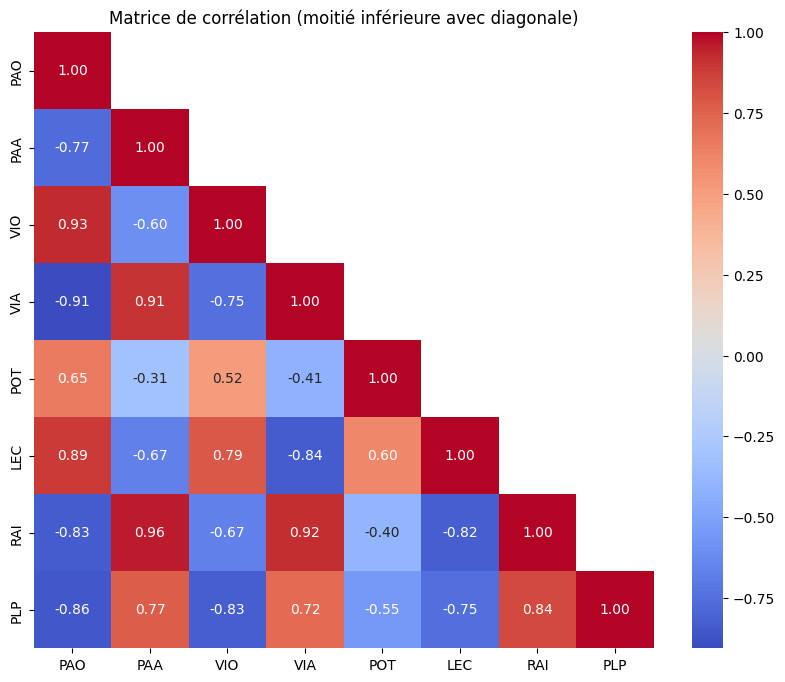

In [161]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matrice de corrélation (moitié inférieure avec diagonale)')
plt.show()


# Application de l'Analyse en Composantes Principales (PCA)
Nous appliquons la PCA pour réduire la dimensionnalité des données. Ensuite, nous calculons les valeurs propres, les pourcentages de variance expliquée et la variance cumulée pour chaque composante principale.

In [162]:
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

pca = PCA()
pca.fit(numeric_data_scaled)

valeurs_propres = pca.explained_variance_
variance_expliquee = pca.explained_variance_ratio_ * 100  
variance_cumulee = np.cumsum(variance_expliquee) 

resultats_pca = pd.DataFrame({
    'N°': np.arange(1, len(valeurs_propres) + 1),
    'Valeur Propre': np.round(valeurs_propres, 4), 
    'Pour-cent': np.round(variance_expliquee, 3),   
    'Cumul': np.round(variance_cumulee, 3)         
})

print(resultats_pca)


   N°  Valeur Propre  Pour-cent    Cumul
0   1         7.0873     77.518   77.518
1   2         1.0277     11.240   88.758
2   3         0.4684      5.123   93.881
3   4         0.3467      3.792   97.673
4   5         0.1896      2.073   99.746
5   6         0.0193      0.211   99.957
6   7         0.0039      0.043  100.000
7   8         0.0000      0.000  100.000


# Projection des individus sur les deux premières composantes principales
Nous projetons les individus sur les deux premières composantes principales et affichons la projection sous forme de nuage de points avec annotation des indices.

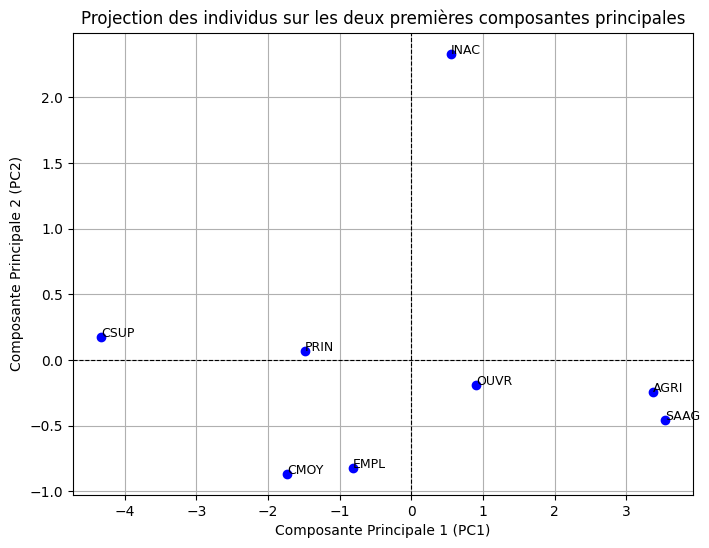

In [163]:
individuals_table = pd.DataFrame(pca.transform(numeric_data_scaled), columns=[f'PC{i+1}' for i in range(numeric_data_scaled.shape[1])])
mirrored_individuals_table = individuals_table.copy()
mirrored_individuals_table['PC1'] = -mirrored_individuals_table['PC1']

plt.figure(figsize=(8, 6))
plt.scatter(mirrored_individuals_table['PC1'], mirrored_individuals_table['PC2'], color='blue', marker='o')

for i, txt in enumerate(data['Index']):
    plt.annotate(txt, (mirrored_individuals_table['PC1'][i], mirrored_individuals_table['PC2'][i]), fontsize=9)

plt.xlabel('Composante Principale 1 (PC1)')
plt.ylabel('Composante Principale 2 (PC2)')
plt.title('Projection des individus sur les deux premières composantes principales')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True)
plt.show()

# Cercle de corrélation
Nous traçons un cercle de corrélation qui montre les relations entre les variables et les deux premières composantes principales.

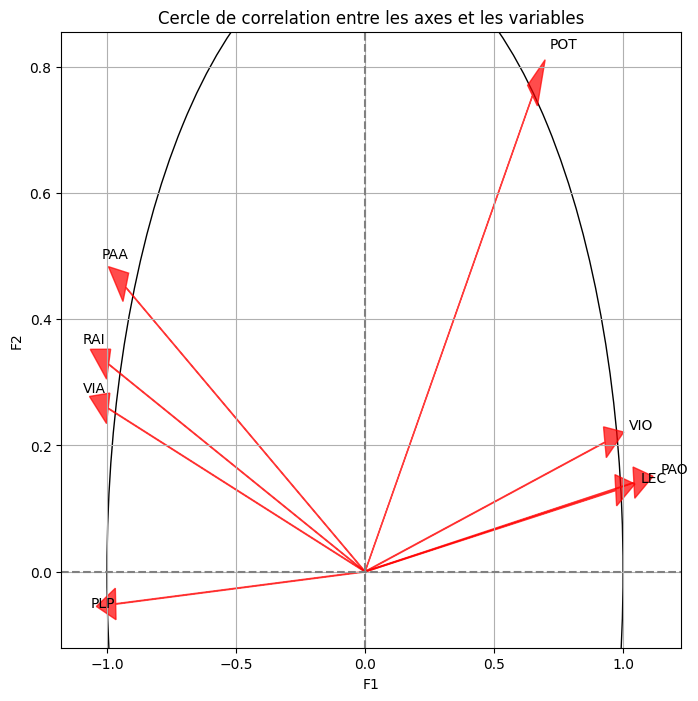

In [164]:
correlations = np.dot(pca.components_[:2, :].T, np.diag(np.sqrt(eigenvalues[:2])))

plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='black', fill=False)
plt.gca().add_artist(circle)

for i in range(correlations.shape[0]):
    plt.arrow(0, 0, -correlations[i, 0], correlations[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(-correlations[i, 0] * 1.1, correlations[i, 1] * 1.1, numeric_data.columns[i], color='black')

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Cercle de correlation entre les axes et les variables')
plt.grid()
plt.show()


# Calcul des contributions et des qualités de représentation
Nous calculons les contributions (CTR) et les qualités de représentation (CO2) des individus sur les deux premières composantes principales. Les contributions indiquent l'importance de chaque individu dans la définition des axes principaux, tandis que les qualités de représentation montrent à quel point les individus sont bien représentés par les axes principaux.


In [168]:
numeric_data_unscaled = data.select_dtypes(include=[np.number]) 

pca = PCA()
pca_results = pca.fit_transform(numeric_data_unscaled)

coordinates = pd.DataFrame(pca_results[:, :2], columns=['F1', 'F2']) * np.sqrt(pca.explained_variance_[:2])

co2 = (coordinates**2).div(np.sum(coordinates**2, axis=1), axis=0) * 1000
ctr = (coordinates**2).div(np.sum(coordinates**2, axis=0), axis=1) * 1000

results = pd.DataFrame({
    'Index': data['Index'],
    'F1': coordinates['F1'].round(0),
    'CO2-1': co2['F1'].round(0),
    'CTR-1': ctr['F1'].round(0),
    'F2': coordinates['F2'].round(0),
    'CO2-2': co2['F2'].round(0),
    'CTR-2': ctr['F2'].round(0),
})

print(results)

  Index      F1   CO2-1  CTR-1     F2  CO2-2  CTR-2
0  AGRI  4797.0   998.0  348.0  212.0    2.0   70.0
1  SAAG  4068.0   998.0  250.0 -178.0    2.0   49.0
2  PRIN -1334.0   941.0   27.0 -333.0   59.0  173.0
3  CSUP -4021.0   991.0  245.0  378.0    9.0  223.0
4  CMOY -2311.0  1000.0   81.0  -46.0    0.0    3.0
5  EMPL -1593.0   990.0   38.0 -158.0   10.0   39.0
6  OUVR  -347.0   557.0    2.0 -309.0  443.0  149.0
7  INAC   742.0   744.0    8.0  435.0  256.0  294.0


***This code snippet prints the sum of two columns, 'CTR-1' and 'CTR-2', from the 'results' DataFrame.***

In [ ]:
print("Sum of CTR-1:", results['CTR-1'].sum()) 
print("Sum of CTR-2:", results['CTR-2'].sum())  

Sum of CTR-1: 999.0
Sum of CTR-2: 1000.0
